In [16]:
%matplotlib widget
import xarray as xr
from ipywidgets import interact
import os
from pathlib import Path
from chapp.hed import HEDDataset
import attr
from groundcontrol.util import dbm2watt
import matplotlib.pyplot as plt
import dask

In [17]:
DATADIR = Path(os.environ["DATADIR"])
WSDIR = Path(os.environ["WORKSPACE"])

PREPROCESS = 'pp1s8'
PPDIR = WSDIR / "preprocess" / PREPROCESS

hedpaths = dict(
    zip(
        ["hep1", "hep2_1", "hep2_2"],
        map(
            lambda s: DATADIR / s,
            [
                "capp8tb6g-he-p1.hednc",
                "capp8tb6g-he-p2__1.hednc",
                "capp8tb6g-he-p2__2.hednc",
            ],
        ),
    )
)

pppaths = dict(
    zip(
        ["hep1", "hep2"],
        map(
            lambda s: PPDIR / s,
            [f"hep1_{PREPROCESS}.nc", f"hep2_{PREPROCESS}.nc"],
        ),
    )
)

EXPS = ['hep1', 'hep2']


def open_pp_dataset(dsname:str, runname: str):
    try:
        ds = xr.open_dataset(pppaths['hep1'], group=f"{runname}/{dsname}")
    except OSError:
        ds = xr.open_dataset(pppaths['hep2'], group=f"{runname}/{dsname}")
    return ds

opd = open_pp_dataset
HDS = HEDDataset.from_path(hedpaths.values())

# QACTIVE SG Fit

Output()

Dropdown(description='Run Name: ', index=3, options=('CD10-R4', 'CD10-R5', 'CD10-R6', 'CD10-R7', 'CD10-R8', 'C…

Dropdown(description='Run Step', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

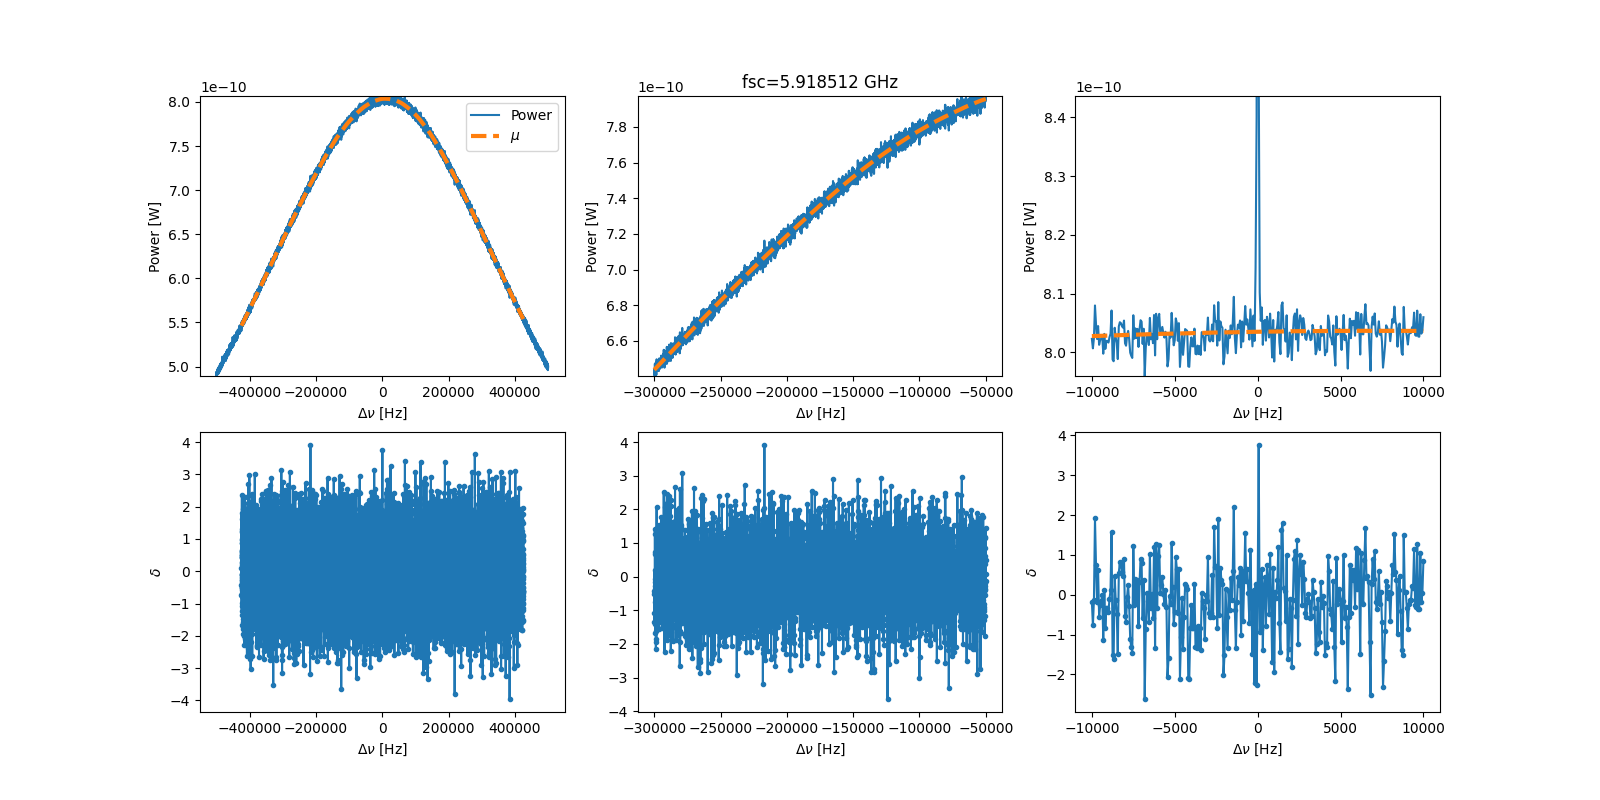

In [18]:
from ipywidgets import Dropdown, Output

runname_w = Dropdown(options=HDS.runtable.index, value='CD10-R7', description="Run Name: ")
runname = runname_w.value
HDS.select(runname)
rsrange = HDS.mastertable.index.unique('runstep').get_level_values('runstep')

runstep_w = Dropdown(options=rsrange, description="Run Step")

globovars = {'delta': None, 'pqa_mu': None, 'pqa': None}

output = Output()

def _handle_runname_chg(change):
    try:
        runname = change.new
    except AttributeError:
        runname = change
        #print(f"Selecting {runname}.")
        HDS.select(runname)
        rsrange = HDS.mastertable.index.unique('runstep').get_level_values('runstep')
        runstep_w.options = rsrange
        delta = opd('delta', runname).delta
        pqa_mu = opd('pqa_mu', runname).pqa_mu
        pqa = HDS.get_dataset('PowSpect-QACTIVE').power_wm
        globovars.update({'delta': delta, 'pqa_mu': pqa_mu, 'pqa': pqa})
        return

    with output:
        if HDS.runname != runname:
            print(f"Selecting {runname}.")
            HDS.select(runname)
            rsrange = HDS.mastertable.index.unique('runstep').get_level_values('runstep')
            runstep_w.options = rsrange
            delta = opd('delta', runname).delta
            pqa_mu = opd('pqa_mu', runname).pqa_mu
            pqa = HDS.get_dataset('PowSpect-QACTIVE').power_wm
            globovars.update({'delta': delta, 'pqa_mu': pqa_mu, 'pqa': pqa})
    output.clear_output()

runname_w.observe(_handle_runname_chg, names='value')

fig = plt.figure(figsize=(16, 8))
axs = []
axs.append(fig.add_subplot(2, 3, 1))
axs.append(fig.add_subplot(2, 3, 2))
axs.append(fig.add_subplot(2, 3, 3))
axs.append(fig.add_subplot(2, 3, 4, sharex=axs[0]))
axs.append(fig.add_subplot(2, 3, 5, sharex=axs[1]))
axs.append(fig.add_subplot(2, 3, 6, sharex=axs[2]))
dnuwindows = (slice(None), slice(-300e3, -50e3), slice(-10e3, 10e3))

def _handle_runstep_chg(change):
    pqa = globovars['pqa']
    pqa_mu = globovars['pqa_mu']
    delta = globovars['delta']
    try:
        runstep = change.new
    except AttributeError:
        runstep = change
    for dnuwind, ax in zip(dnuwindows, axs[:3]):
        ax.clear()
        pqasel = pqa.sel(dnu=dnuwind, runstep=runstep)
        ylim = pqasel.quantile([0.0001, 0.995])
        pqasel.plot(
            ax=ax, label=pqa.attrs["long_name"], ylim=ylim
        )
        pqa_mu.sel(dnu=dnuwind, runstep=runstep).plot(
            ax=ax, linestyle="--", linewidth=3, label="$\mu$" # pqa_mu.attrs["long_name"]
        )
        ax.set_ylabel("Power [W]")
        if ax is axs[0]:
            ax.legend()

    for dnuwind, ax in zip(dnuwindows, axs[3:]):
        ax.clear()
        delta.sel(dnu=dnuwind, runstep=runstep).plot(
            ax=ax, marker="o", markersize=3
        )

    [axs[i].set_title("") for i in range(6) if i != 1]
    axs[1].set_title(f"fsc={pqasel.fsc.item()/1e9:.6f} GHz")
    fig.canvas.draw()

runstep_w.observe(_handle_runstep_chg, names='value')

_handle_runname_chg(runname_w.value)
_handle_runstep_chg(runstep_w.value)

display(output, runname_w, runstep_w)

In [19]:
from chapp.plotting import signoiseplot

(<Figure size 640x480 with 2 Axes>,
 [<AxesSubplot:>, <AxesSubplot:xlabel='Count'>])

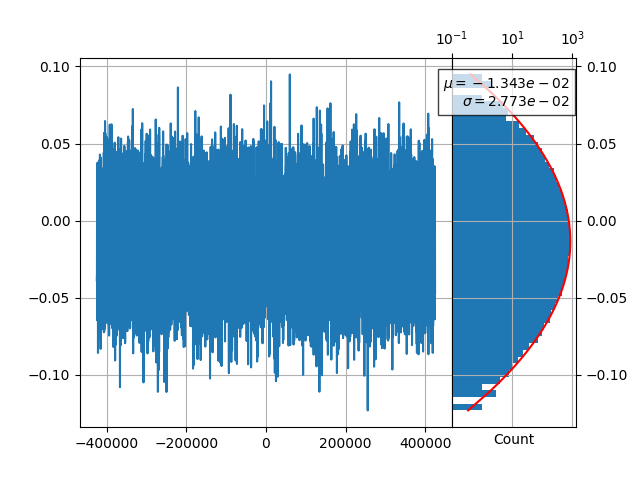

In [34]:
delta = globovars['delta']
delta = delta.where((delta.dnu < -500) | (delta.dnu > 500)).mean(dim='runstep').dropna(dim='dnu')
signoiseplot(delta.dnu.data, delta.data, bins=50)

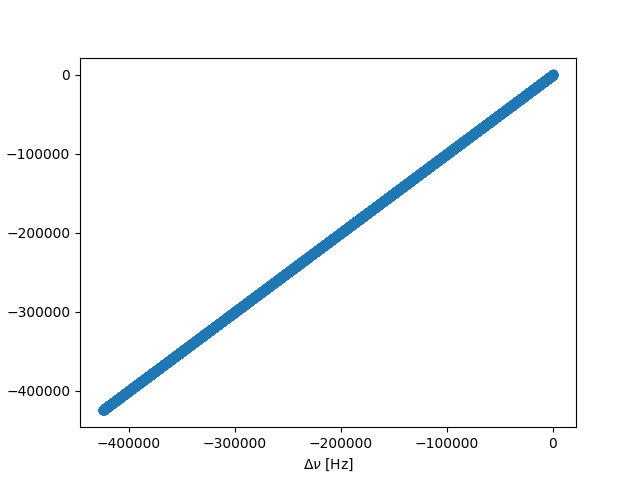

In [33]:
plt.figure()
delta.dnu.where((delta.dnu < -187.5) | (delta.dnu > 187.5)).plot.
plt.show()

# Noise Temperature

CPU times: user 3.01 s, sys: 1.06 s, total: 4.08 s
Wall time: 10.1 s


Text(0, 0.5, '$T_{sys}$ [K]')

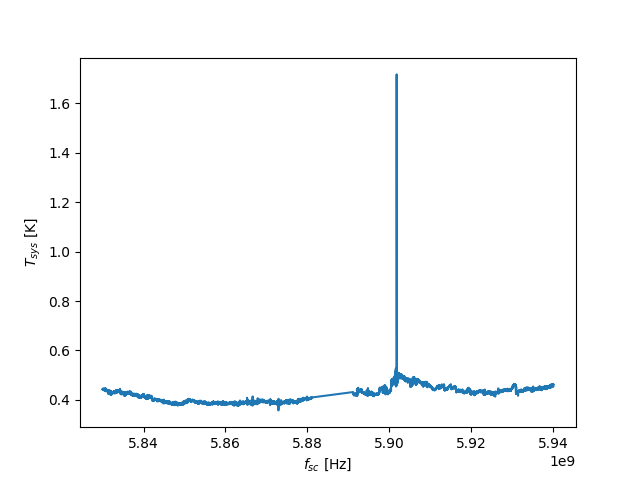

In [4]:
%%time
# Compile all together
tsys_l = []
runnames = list(HDS.runtable.index)
for runname in runnames:
    tsys_l.append(
        opd("tsys", runname).chunk({"runstep": 7}).tsys.mean(dim="dnu", keep_attrs=True)
    )

# parallel computation
DS_TSYS = (
    xr.concat(dask.compute(*tsys_l), dim="run")
    .assign_coords(run=("run", runnames))
    .stack(grunstep=["run", "runstep"])
    .dropna("grunstep")
)

# initial concat creates nans because each runstep have different number of runs.
# stacking and dropna then gets rid of these unnecessary nans.
# there is probably a much more efficient way of turning it into a stacked dataset, anyway its not too much data.


fig, ax = plt.subplots()
DS_TSYS.plot(x='fsc', ax=ax)
ax.set_ylabel("$T_{sys}$ [K]")

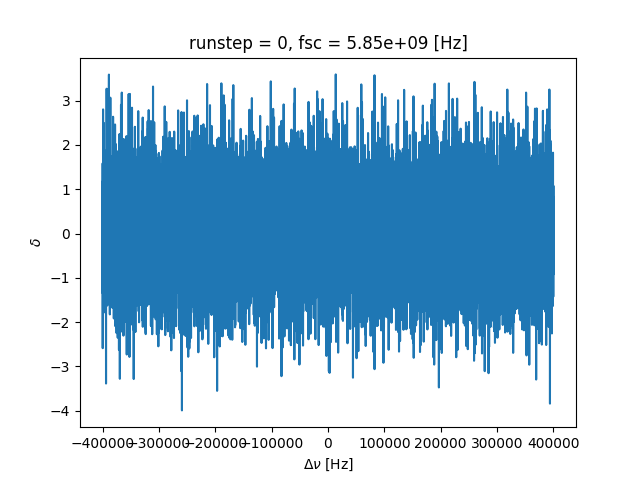

In [33]:
delta = opd('delta', 'CD12-R4')
fig, ax = plt.subplots()
#delta.delta.mean(dim='runstep').plot(ax=ax, ylim=(-0.5,0.5))
delta.delta.sel(runstep=0).plot()

In [34]:
from chapp.plotting import signoiseplot

(<Figure size 640x480 with 2 Axes>,
 [<AxesSubplot:>, <AxesSubplot:xlabel='Count'>])

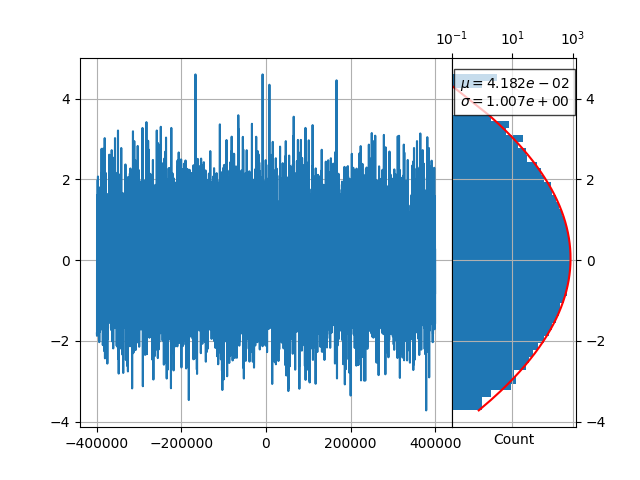

In [42]:
signoiseplot(delta.dnu.data, delta.delta.sel(runstep=100).data)